<a href="https://colab.research.google.com/github/sudhirshahu51/Pytorch_Codes/blob/main/cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN model([pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html))

Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
batch_size = 4

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 50.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
trainloader

In [6]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
#trainloader

In [24]:
trainloader

In [11]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

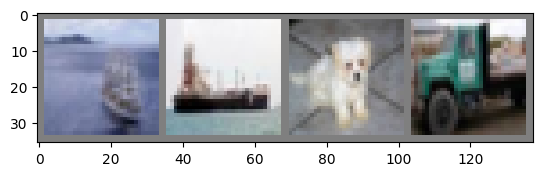

ship  ship  dog   truck


In [12]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

**Define a Convolutional Neural Network**

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

**Define a Loss function and optimizer**

In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**4. Train the network**

In [31]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.890
[1,  4000] loss: 0.912
[1,  6000] loss: 0.925
[1,  8000] loss: 0.944
[1, 10000] loss: 0.948
[1, 12000] loss: 0.949
[2,  2000] loss: 0.856
[2,  4000] loss: 0.879
[2,  6000] loss: 0.882
[2,  8000] loss: 0.904
[2, 10000] loss: 0.893
[2, 12000] loss: 0.914
Finished Training


save our trained model:

In [32]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

**5. Test the network on the test data**

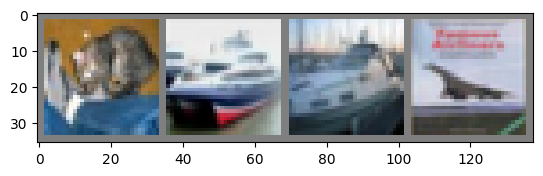

GroundTruth:  cat   ship  ship  plane


In [33]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [34]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [35]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [36]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   truck plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [37]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        print()
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [38]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 73.4 %
Accuracy for class: car   is 83.8 %
Accuracy for class: bird  is 44.1 %
Accuracy for class: cat   is 42.5 %
Accuracy for class: deer  is 56.2 %
Accuracy for class: dog   is 50.5 %
Accuracy for class: frog  is 65.2 %
Accuracy for class: horse is 72.0 %
Accuracy for class: ship  is 69.6 %
Accuracy for class: truck is 64.3 %


In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that device is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [44]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Remember that you will have to send the inputs and targets at every step to the GPU too:

In [45]:
inputs, labels = data[0].to(device), data[1].to(device)